## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
from urllib.parse import urlparse
from scipy.stats import spearmanr

from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset2, TextDataset3
from bert import CustomBert, HeadNet
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

Using TensorFlow backend.


## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train = clean_data(train, INPUTS)
test = clean_data(test, INPUTS)

In [4]:
train['question'] = train['question_title'] + ' \n \n \n ' + train['question_body']
test['question'] = test['question_title'] + ' \n \n \n ' + test['question_body']

In [5]:
init_seed()

In [6]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer', 'question_title']:
        ids = []
        for x in tqdm(df[text].values):
            x = " ".join(x.strip().split()[:300])
            tok = tokenizer.encode(x, add_special_tokens=True)
            ids.append(tok[:max_seq_len])
        ids = np.array([i + [0] * (max_seq_len - len(i)) for i in ids])
        if mode == 'train': ids_train[text] = ids
        else: ids_test[text] = ids

100%|██████████| 476/476 [00:00<00:00, 5980.56it/s]

CPU times: user 21.6 s, sys: 143 ms, total: 21.8 s
Wall time: 22.1 s


In [7]:
# %%time
# distill_bert_feature_path = 'proc_data/distill_bert_features/'
# bert_features_train, bert_features_test = get_distill_bert_features(
#     train, test, ['question_body', 'answer'], 64, distill_bert_feature_path)

In [8]:
%%time
use_feature_path = 'proc_data/use_embedding_features/'
embedding_train, embedding_test = get_use_embedding_features(train, test, INPUTS, use_feature_path)

CPU times: user 1.15 s, sys: 28 ms, total: 1.18 s
Wall time: 1.18 s


In [9]:
%%time
dist_features_train, dist_features_test  = get_dist_features(embedding_train, embedding_test)

CPU times: user 1.15 s, sys: 19 ms, total: 1.17 s
Wall time: 118 ms


In [10]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [11]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)

cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [12]:
x_features_train = np.hstack([cat_features_train, dist_features_train])
x_features_test = np.hstack([cat_features_test, dist_features_test])

In [13]:
y = train[TARGETS].values.astype(np.float32)

In [14]:
num_workers = 10
bs = 4

In [15]:
bs_test = 4
test_loader = DataLoader(
    TextDataset2(x_features_test, embedding_test['question_body_embedding'], 
                 embedding_test['answer_embedding'], embedding_test['question_title_embedding'], 
                 ids_test['question'], ids_test['answer'], ids_test['question_title'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [16]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 6
grad_accum = 8
weight_decay = 0.01
model_name = 'distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [17]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return optim.Adam([#params=model.parameters(), lr=lr)#[
                {'params': model.head.parameters(), 'lr': lr},
                {'params': model.q_bert.parameters(), 'lr': lr/100},
                {'params': model.a_bert.parameters(), 'lr': lr/100}
            ])


def get_optimizer(model, lr, weight_decay):
    #return optim.Adam([#params=model.parameters(), lr=lr)#[
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Mon Dec  9 18:50:22 2019


  0%|          | 0/800 [00:00<?, ?it/s]/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
 78%|███████▊  | 624/800 [01:49<00:32,  5.40it/s]

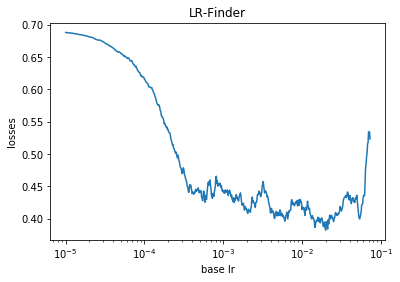

epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46416 - spearmanr 0.11169
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39357 - spearmanr 0.31289
best model: epoch 0 - 0.31289
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.37848 - spearmanr 0.33946
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.37127 - spearmanr 0.39252
best model: epoch 1 - 0.39252
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36065 - spearmanr 0.40766
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36872 - spearmanr 0.40257
best model: epoch 2 - 0.40257
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35044 - spearmanr 0.44563
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36888 - spearmanr 0.40536
best model: epoch 3 - 0.40536
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34164 - spearmanr 0.47729
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36862 - spearmanr 0.4079
best model: epoch 4 - 0.4079
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.3361 - spearmanr 0.49985
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.3694 - spearmanr 0.40751
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 4 - 0.40790
Starting inference for model: checkpoints/distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/distil_bert_fold_1_best.pth



Fold 2 started at Mon Dec  9 19:17:11 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46475 - spearmanr 0.11633
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.38921 - spearmanr 0.31798
best model: epoch 0 - 0.31798
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.37961 - spearmanr 0.337
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.37096 - spearmanr 0.39774
best model: epoch 1 - 0.39774
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36182 - spearmanr 0.40614
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36316 - spearmanr 0.40868
best model: epoch 2 - 0.40868
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35108 - spearmanr 0.44827
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36172 - spearmanr 0.41625
best model: epoch 3 - 0.41625
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34317 - spearmanr 0.47531
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36174 - spearmanr 0.41491
model not improved for 1 epochs
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.33734 - spearmanr 0.49651
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36285 - spearmanr 0.41393
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 3 - 0.41625
Starting inference for model: checkpoints/distil_bert_fold_2_best.pth



Starting inference for model: checkpoints/distil_bert_fold_2_best.pth



Fold 3 started at Mon Dec  9 19:41:46 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46575 - spearmanr 0.10967
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.39062 - spearmanr 0.32356
best model: epoch 0 - 0.32356
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.37909 - spearmanr 0.33897
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.36815 - spearmanr 0.39674
best model: epoch 1 - 0.39674
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36192 - spearmanr 0.40384
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.3641 - spearmanr 0.41055
best model: epoch 2 - 0.41055
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35145 - spearmanr 0.44619
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36334 - spearmanr 0.41356
best model: epoch 3 - 0.41356
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34305 - spearmanr 0.47538
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36325 - spearmanr 0.41694
best model: epoch 4 - 0.41694
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.3375 - spearmanr 0.49572
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36402 - spearmanr 0.41712
best model: epoch 5 - 0.41712
TRAINING END: Best score achieved on epoch 5 - 0.41712
Starting inference for model: checkpoints/distil_bert_fold_3_best.pth



Starting inference for model: checkpoints/distil_bert_fold_3_best.pth



Fold 4 started at Mon Dec  9 20:06:24 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46409 - spearmanr 0.11578
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.38868 - spearmanr 0.32768
best model: epoch 0 - 0.32768
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.37883 - spearmanr 0.34183
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.3664 - spearmanr 0.39656
best model: epoch 1 - 0.39656
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36206 - spearmanr 0.4073
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36238 - spearmanr 0.40816
best model: epoch 2 - 0.40816
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.3516 - spearmanr 0.44841
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36339 - spearmanr 0.41565
best model: epoch 3 - 0.41565
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.343 - spearmanr 0.47922
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36237 - spearmanr 0.41412
model not improved for 1 epochs
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.33708 - spearmanr 0.50047
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36251 - spearmanr 0.41354
model not improved for 2 epochs
TRAINING END: Best score achieved on epoch 3 - 0.41565
Starting inference for model: checkpoints/distil_bert_fold_4_best.pth



Starting inference for model: checkpoints/distil_bert_fold_4_best.pth



Fold 5 started at Mon Dec  9 20:30:59 2019
epoch 0: 	 Start training...



epoch 0/6 	 train : loss 0.46459 - spearmanr 0.1252
epoch 0: 	 Start validation...



epoch 0/6 	 valid : loss 0.3915 - spearmanr 0.32164


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.32164
epoch 1: 	 Start training...



epoch 1/6 	 train : loss 0.37842 - spearmanr 0.3403
epoch 1: 	 Start validation...



epoch 1/6 	 valid : loss 0.3718 - spearmanr 0.39418
best model: epoch 1 - 0.39418
epoch 2: 	 Start training...



epoch 2/6 	 train : loss 0.36171 - spearmanr 0.40746
epoch 2: 	 Start validation...



epoch 2/6 	 valid : loss 0.36606 - spearmanr 0.40781
best model: epoch 2 - 0.40781
epoch 3: 	 Start training...



epoch 3/6 	 train : loss 0.35125 - spearmanr 0.44758
epoch 3: 	 Start validation...



epoch 3/6 	 valid : loss 0.36506 - spearmanr 0.41026
best model: epoch 3 - 0.41026
epoch 4: 	 Start training...



epoch 4/6 	 train : loss 0.34259 - spearmanr 0.47817
epoch 4: 	 Start validation...



epoch 4/6 	 valid : loss 0.36493 - spearmanr 0.41189
best model: epoch 4 - 0.41189
epoch 5: 	 Start training...



epoch 5/6 	 train : loss 0.33667 - spearmanr 0.49992
epoch 5: 	 Start validation...



epoch 5/6 	 valid : loss 0.36464 - spearmanr 0.41152
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 4 - 0.41189
Starting inference for model: checkpoints/distil_bert_fold_5_best.pth



Starting inference for model: checkpoints/distil_bert_fold_5_best.pth



OOF score: 0.41154455580505955


In [18]:
folds = KFold(n_splits=5, random_state=42)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds.split(train)):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
                     embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
                     ids_train['question'], ids_train['answer'], ids_train['question_title'], 
                     train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset2(x_features_train, embedding_train['question_body_embedding'], 
                     embedding_train['answer_embedding'], embedding_train['question_title_embedding'], 
                     ids_train['question'], ids_train['answer'], ids_train['question_title'], 
                     valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
        
    model = CustomBert(256)
    
    if fold_id == 0:
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / folds.n_splits
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4119


In [19]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [20]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.925451,0.623976,0.110014,0.493142,0.768226,0.745578,0.670317,0.611808,0.601033,0.001980,0.498681,0.612734,0.005860,0.151217,0.004182,0.006933,0.083091,0.102152,0.796357,0.001011,0.898220,0.913116,0.568890,0.959222,0.971115,0.827469,0.006124,0.025408,0.895492,0.922375
1,46,0.861059,0.517455,0.002452,0.729760,0.787176,0.928673,0.564731,0.483070,0.020018,0.006030,0.446351,0.141192,0.001687,0.000422,0.000264,0.002770,0.922182,0.181262,0.094074,0.000184,0.653352,0.960547,0.670640,0.981831,0.989655,0.891382,0.951826,0.091018,0.060020,0.915716
2,70,0.919742,0.678902,0.010618,0.756087,0.933741,0.969914,0.587342,0.469371,0.212539,0.002215,0.162987,0.686019,0.014562,0.046576,0.003086,0.004188,0.053953,0.047119,0.764765,0.000944,0.851715,0.939566,0.629730,0.974785,0.977592,0.846179,0.014820,0.026080,0.944624,0.924864
3,132,0.910417,0.414519,0.004314,0.658470,0.762770,0.856761,0.575426,0.468139,0.180435,0.002693,0.582791,0.050026,0.001142,0.000828,0.000326,0.016614,0.912299,0.269791,0.449688,0.000138,0.742739,0.942109,0.712088,0.974362,0.979376,0.875951,0.705387,0.175400,0.817665,0.928268
4,200,0.940951,0.508202,0.014352,0.842867,0.887209,0.938136,0.664827,0.630814,0.264261,0.007587,0.264057,0.414449,0.009165,0.018916,0.003784,0.026614,0.188277,0.130115,0.639363,0.002227,0.763325,0.888923,0.639440,0.954954,0.954275,0.802568,0.098194,0.105951,0.658987,0.904994
